<a href="https://colab.research.google.com/github/AShahLab/ToxicComments_NLP/blob/main/Kaggle_Project_AS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TOXIC COMMENTS NATURAL LANGUAGE PROCESSING
**Name:** Awais Shah

**Date:** Feb 29

--

### Problem Statement

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

toxic  
severe_toxic  
obscene  
threat  
insult  
identity_hate   

You must create a model which predicts a probability of each type of toxicity for each comment. 
The metric we will be using is ROC AUC 

Link to raw data



##### [https://drive.google.com/drive/folders/13ql-6srXUHyOqTyWrKowPOWjmji-3kqA?usp=sharing)
--

To document my weekly progress in this Kaggle project, I've taken notes in the following Google Doc: https://docs.google.com/document/d/1uqpjUP6hm1SOeIPMIRXsP7SGDG-ssX5j1FdbZoICdZE/edit?usp=sharing

Import required packages for this notebook.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import f1_score,ConfusionMatrixDisplay, classification_report,RocCurveDisplay, precision_recall_curve, accuracy_score, confusion_matrix,precision_score,recall_score,roc_curve,roc_auc_score
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
# import mglearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words as stop_words
from sklearn.model_selection import  RepeatedStratifiedKFold
import string
import re
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.ma.core import mean
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN   
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from imblearn.over_sampling import SMOTE
from sklearn.metrics._plot.roc_curve import plot_roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc

## Load the data

This mounts your Google Drive at the location `/content/drive` on the virtual machine running this notebook.

In [ ]:
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/Kaggle/train.csv'
test_filepath='/content/drive/My Drive/Kaggle/test.csv'
test_labels_filepath='/content/drive/My Drive/Kaggle/test_labels.csv'
df=pd.read_csv(filepath)
df_test_comments=pd.read_csv(test_filepath)
df_test_labels=pd.read_csv(test_labels_filepath)
df_test=pd.merge(df_test_comments,df_test_labels,on=['id'])

Mounted at /content/drive


I want to ensure I can see the full text for the first few rows of the training data set

In [ ]:
pd.set_option('display.max_colwidth',10000)

After bringing the data in, we can see what the data looks like. The comment_text column seems to have some grammatical issues that need to be cleaned and we can also see that our Y variable is multiple columns i.e. it is a multilabel classification problem

In [ ]:
df=pd.read_csv(filepath)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [ ]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Defining the problem: EDA and Data Pre-processing

Following code calculates impurity values i.e. impure portion document length divided by length of full document. Impurity here is defined by `RE_SUSPICIOUS=re.compile(r'[&#<>{}\[\]\\]')`

In [ ]:
# Let's clean some of the data. As you can see, there are a lot of transfer notations that may cause our model to not perform at its best.
import re
imp=[]
RE_SUSPICIOUS=re.compile(r'[&#<>{}\[\]\\]')
def impurity(text,min_len=10):
  # returns bad text
  if text==None or len(text)<min_len:
    return 0
  else:
    return len(RE_SUSPICIOUS.findall(text))/len(text)

[imp.append(impurity(df["comment_text"][i])) for i,text in enumerate(df["comment_text"])]
  
print(mean(imp))


0.000903229409441793


Our impurity score is pretty low but we still want to get rid of some transfer notations that can affect our test results. We will now set up a function to clean up the data before doing our EDA

In [ ]:
def clean(text):
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==”
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
df["comment_text"]=df["comment_text"].apply(clean)
df_test["comment_text"]=df_test["comment_text"].apply(clean)

In [ ]:
df["comment_text"]=df["comment_text"].apply(decontracted)
df_test["comment_text"]=df_test["comment_text"].apply(decontracted)

In [ ]:
mean(df["comment_text"].apply(impurity))

0.0007250642838586591

As you can see our impurity levels have gone down. Let's look at the data one more time before we move on.

In [ ]:
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They were not vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please do not remove the template from the talk page since I am retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I am seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I am really not trying to edit war. It is just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can not make any real suggestions on improvement I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It is listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that is on?",0,0,0,0,0,0


We can now look at the count of each class and look for disparities in the dataset that may influence our output metric or our predictions. The skewness that is evident in a majority of the data is leaning toxic, obscene, and insult (in that order); whereas severe_toxic, threat, and identity_hate have minimal occurences. We should note that threat is the worst-case in this data due to its minimal data so we would be using that as our basis in terms of judging performance as we go forward.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of Occurences')

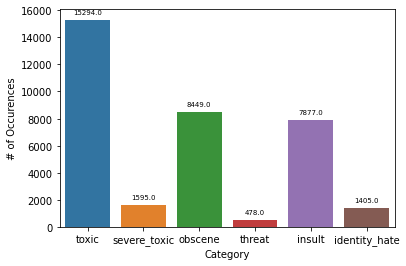

In [ ]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y=np.array(df[categories])
sum=np.sum(y,axis=0)

plots=sns.barplot(categories,sum)
for bar in plots.patches:
  plt.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')
plt.xlabel("Category")
plt.ylabel("# of Occurences")

We can also look at the multiclass labels for each instance. The one trend we notice is an emphasis on rows where all categories are 0. This is an imbalanced dataset. Let's look at the distribution of the X variable i.e. Comment_text to see any patterns.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """


Text(0, 0.5, '# of Occurences')

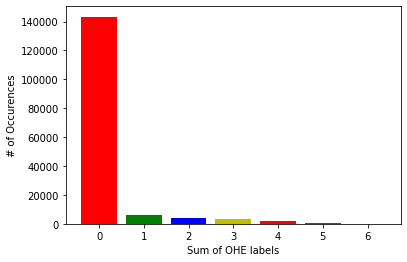

In [ ]:
sum=np.sum(df[categories],axis=1)
sum=sum.value_counts().reset_index(name="cnt")
labels =  np.arange(0,7)
# labels
plt.bar(labels,sum["cnt"],color="rgby")

plt.xlabel("Sum of OHE labels")
plt.ylabel("# of Occurences")


We also want to know the mean length of our text, which will be used as an intuition later when we are working on text vectorization.

In [ ]:
print("Mean length of document: {0:.2f}\nTotal number of documents in the corpus: {1:}".format(df['comment_text'].str.len().mean(),len(df['comment_text'])))

Mean length of document: 391.78
Total number of documents in the corpus: 159571


In [ ]:
print("{0:.2f}% of the documents are greater than 400 document length".format((np.sum(df['comment_text'].str.len()>400)/len(df['comment_text']))*100))

27.22% of the documents are greater than 400 document length


Threat seems to be the most imbalanced label as shown below in terms of percentage of the total count


In [ ]:
for category in categories:
  print("{0:s}: {1:.2f}%".format(category,mean(df[category])*100))

toxic: 9.58%
severe_toxic: 1.00%
obscene: 5.29%
threat: 0.30%
insult: 4.94%
identity_hate: 0.88%


Let's dive a little deeper into this imbalance problem.

In [ ]:
df[categories].value_counts()

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                143346
1      0             0        0       0       0                  5666
                     1        0       1       0                  3800
                                      0       0                  1758
                     0        0       1       0                  1215
       1             1        0       1       0                   989
       0             1        0       1       1                   618
0      0             1        0       0       0                   317
                     0        0       1       0                   301
1      1             1        0       1       1                   265
0      0             1        0       1       0                   181
1      1             1        0       0       0                   158
       0             0        0       0       1                   136
                              

The distibution plot shows a skewness in the length of the document, where the majority of stays within the range of 0-1000 characters. The max goes all the way to 5000 in certain cases

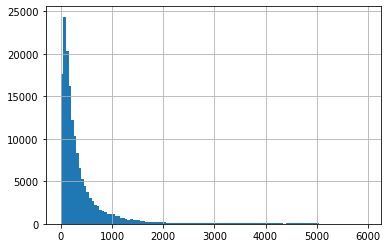

In [ ]:
commentlen=df["comment_text"].str.len()
commentlen.hist(bins=np.arange(0,6000,50))

Let's check if there are any empty comments



In [ ]:
commentleng=df[(df["comment_text"].str.len()==0)]
# below is another way---probably simpler
print("Comments")
print('train',df['comment_text'].isnull().sum())
print('test',df_test['comment_text'].isnull().sum())
# df.drop(commentleng,axis=0,inplace=True)
print("Categories")
print('train',df[categories].isnull().sum())
print('test',df_test[categories].isnull().sum())

Comments
train 0
test 0
Categories
train toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
test toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
df.shape

(159571, 8)

In [ ]:
df_test.shape

(153164, 8)

Let's just look at the test data a little bit and make sure the one hot encoding makes sense

In [ ]:
df_test.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you will ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",-1,-1,-1,-1,-1,-1
1,0000247867823ef7,"From RfC The title is fine as it is, IMO.",-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" Sources * Zawe Ashton on Lapland — / """,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source had not updated. I shall update the information once again but thank you for your message.",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I do not anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
6,00024115d4cbde0f,"Please do not add nonsense to Wikipedia. Such edits are considered vandalism and quickly undone. If you would like to experiment, please use the sandbox instead. Thank you.",-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
8,00025358d4737918,""" Only a fool can believe in such numbers. The correct number lies between 10 000 to 15 000. Ponder the numbers carefully. This error will persist for a long time as it continues to reproduce... The latest reproduction I know is from ENCYCLOPÆDIA BRITANNICA ALMANAC 2008 wich states Magnittude: 8.7 (fair enough) victims: 70 000 (today 10 000 to 15 000 is not """"a lot"""" so I guess people just come out with a number that impresses enough, I do not know. But I know this: it is just a shameless lucky number that they throw in the air. GC """,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,"Double Redirects When fixing double redirects, do not just blank the outer one, you need edit it to point it to the final target, unless you think it is inappropriate, in which case, it needs to be nominated at WP:RfD",-1,-1,-1,-1,-1,-1


The -1 are documents that have not been scored yet. We can drop them since this will affect our metrics

In [ ]:
np.sum(df_test['toxic']==-1)

89186

In [ ]:
df_test=df_test[df_test['toxic']!=-1]

In [ ]:
df_test.shape

(63978, 8)

In [ ]:
X_train_dtm=df['comment_text']
X_test_dtm=df_test['comment_text']
print("Vectorized feature shapes:\nX_train_dtm: {}\nX_test_dtm: {}".format(X_train_dtm.shape,X_test_dtm.shape))

Vectorized feature shapes:
X_train_dtm: (159571,)
X_test_dtm: (63978,)


# PART 1: CORE ML Classification Models

## **BASIC LOGISTIC REGRESSION WITH CV**

Our base model below gives us the ROC AUC values that seem particularly inflated without doing any sort of data adjustment to better the imbalance. 

Mean ROC AUC Score for toxic: 0.969
Mean ROC AUC Score for severe_toxic: 0.985
Mean ROC AUC Score for obscene: 0.985
Mean ROC AUC Score for threat: 0.980
Mean ROC AUC Score for insult: 0.975
Mean ROC AUC Score for identity_hate: 0.973
Average ROC AUC over all categories is: 0.98


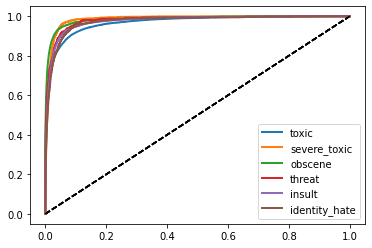

In [ ]:
pipeline=Pipeline([('tfid', TfidfVectorizer(stop_words="english")), ('logistic', LogisticRegression())])
mean_roc=[]
for category in categories:
  LR_y_pred = cross_val_predict(pipeline, X_train_dtm, df[category],cv=3, n_jobs=-1,method="decision_function")
  mean_roc.append(roc_auc_score(df[category],LR_y_pred))
  fpr,tpr,thresholds=roc_curve(df[category],LR_y_pred)
  plt.plot(fpr, tpr, linewidth=2, label=category)
  plt.plot([0, 1], [0, 1], 'k--')
  print('Mean ROC AUC Score for '+category+': %.3f' % roc_auc_score(df[category],LR_y_pred))
print("Average ROC AUC over all categories is: {0:.2f}".format(np.mean(mean_roc)))
plt.legend()
plt.show()

We will try to bring some balance into our dataset by using `class_weight='balanced'`

Mean ROC AUC Score for toxic: 0.969
Mean ROC AUC Score for severe_toxic: 0.984
Mean ROC AUC Score for obscene: 0.985
Mean ROC AUC Score for threat: 0.980
Mean ROC AUC Score for insult: 0.976
Mean ROC AUC Score for identity_hate: 0.974
Average ROC AUC over all categories is: 0.98


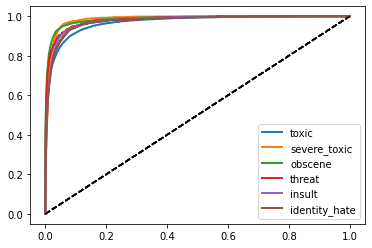

In [ ]:
model_balanced=Pipeline([('tfid', TfidfVectorizer(stop_words="english")), ('logistic', LogisticRegression(class_weight="balanced"))])
mean_roc_b=[]
for category in categories:
  LR_y_pred_b = cross_val_predict(model_balanced, X_train_dtm, df[category],cv=3, n_jobs=-1,method='decision_function')
  mean_roc_b.append(roc_auc_score(df[category],LR_y_pred_b))
  fpr,tpr,thresholds=roc_curve(df[category],LR_y_pred_b)
  plt.plot(fpr, tpr, linewidth=2, label=category)
  plt.plot([0, 1], [0, 1], 'k--')
  print('Mean ROC AUC Score for '+category+': %.3f' % roc_auc_score(df[category],LR_y_pred_b))
print("Average ROC AUC over all categories is: {0:.2f}".format(np.mean(mean_roc_b)))
plt.legend()
plt.show()

That did not do anything for our worst class (Threat). We can also try to oversample our positive class manually. In this case we can try an extreme example of 1:300 and compare our results from above.

Mean ROC AUC Score for toxic: 0.895
Mean ROC AUC Score for severe_toxic: 0.899
Mean ROC AUC Score for obscene: 0.946
Mean ROC AUC Score for threat: 0.814
Mean ROC AUC Score for insult: 0.926
Mean ROC AUC Score for identity_hate: 0.855
Average ROC AUC over all categories is: 0.89


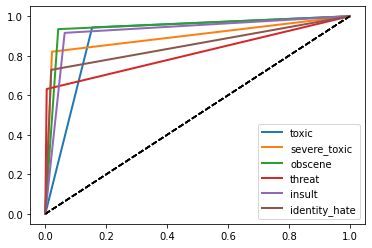

In [ ]:
model_adj_weights=Pipeline([('tfid', TfidfVectorizer(stop_words="english")), ('logistic', LogisticRegression(class_weight={0:1,1:300}))])
mean_roc_adj_weights=[]
for category in categories:
  LR_y_pred_adj_weights = cross_val_predict(model_adj_weights, X_train_dtm, df[category],cv=3, n_jobs=-1)
  mean_roc_adj_weights.append(roc_auc_score(df[category],LR_y_pred_adj_weights))
  fpr,tpr,thresholds=roc_curve(df[category],LR_y_pred_adj_weights)
  plt.plot(fpr, tpr, linewidth=2, label=category)
  plt.plot([0, 1], [0, 1], 'k--')
  print('Mean ROC AUC Score for '+category+': %.3f' % roc_auc_score(df[category],LR_y_pred_adj_weights))
print("Average ROC AUC over all categories is: {0:.2f}".format(np.mean(mean_roc_adj_weights)))
plt.legend()
plt.show()

Manual oversampling worked on average for our model but for Threat class, the results were underwhelming. We can also try SMOTE. This adds new examples that can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

Mean ROC AUC Score for toxic: 0.881


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean ROC AUC Score for severe_toxic: 0.895
Mean ROC AUC Score for obscene: 0.919
Mean ROC AUC Score for threat: 0.822
Mean ROC AUC Score for insult: 0.898
Mean ROC AUC Score for identity_hate: 0.848
Average ROC AUC over all categories is: 0.88


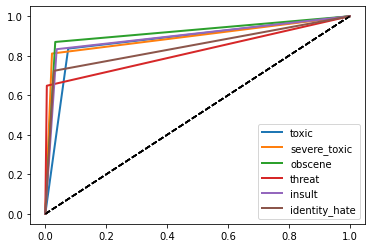

In [ ]:
steps = [('tfid', TfidfVectorizer(stop_words="english")),('over', SMOTE()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)
mean_roc_smote=[]
for category in categories:
  LR_y_pred_smote = cross_val_predict(pipeline, X_train_dtm, df[category],cv=3, n_jobs=-1)
  mean_roc_smote.append(roc_auc_score(df[category],LR_y_pred_smote))
  fpr,tpr,thresholds=roc_curve(df[category],LR_y_pred_smote)
  plt.plot(fpr, tpr, linewidth=2, label=category)
  plt.plot([0, 1], [0, 1], 'k--')
  print('Mean ROC AUC Score for '+category+': %.3f' % roc_auc_score(df[category],LR_y_pred_smote))
print("Average ROC AUC over all categories is: {0:.2f}".format(np.mean(mean_roc_smote)))
plt.legend()
plt.show()

It will be hard to beat the metrics from Logistic regression, but we will go on and try other methods to get a better intuition of how other methods work and the inherent differences that lead to different results.

## **MULTILABEL KNEIGHBORS CLASSIFICATION**

We move on to KNeighborsClassifier with a multilabel average-macro.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf=Pipeline([('tfid', TfidfVectorizer(stop_words="english")), ('knn', KNeighborsClassifier())])
y_multilabel=df[categories]
y_train_pred_kn=cross_val_predict(knn_clf,X_train_dtm,y_multilabel,cv=3)
print("roc auc",roc_auc_score(y_multilabel,y_train_pred_kn,average="macro"))

roc auc 0.5588603970631979


## **DECISION TREE CLASSIFICATION**

Below we use a decision tree classifier with class weights used to adjust the imbalance. 

In [ ]:
dt_clf=Pipeline([('tfid', TfidfVectorizer(stop_words="english")), ('dectree', DecisionTreeClassifier(class_weight='balanced'))])
for category in categories:
  DT_y_pred = cross_val_predict(dt_clf, X_train_dtm, df[category], method='predict_proba',cv=3,  n_jobs=-1)
  y_scores_forest=DT_y_pred[:,1]
  fpr_forest,tpr_forest,threshold_forest=roc_curve(df[category],y_scores_forest)
  ac=auc(fpr_forest,tpr_forest)
  print("AUC for {0:s}: {1:.2f}".format(category,ac))

AUC for toxic: 0.83
AUC for severe_toxic: 0.73
AUC for obscene: 0.89
AUC for threat: 0.70
AUC for insult: 0.84
AUC for identity_hate: 0.71


## **GRADIENT BOOSTING WITH XGBOOST AND STRATIFIED K-FOLD CV**

We can try XGBoost with StratifiedKFold CV to ensure a good distribution of imbalanced labels. Using XGBoost will also allow for a sequential gradient boosting and fixing of errors to get the best accuracy.

In [ ]:
import xgboost
kfold = StratifiedKFold(n_splits=5)
model=Pipeline([('tfid', TfidfVectorizer(stop_words="english")), ('gboosting',xgboost.XGBClassifier())])
# fit model no training data
for category in categories:
  results = cross_val_score(model, X_train_dtm, df[category], cv=kfold)
  print(category)
  print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


toxic
Accuracy: 93.84% (0.09%)
severe_toxic
Accuracy: 99.02% (0.02%)
obscene
Accuracy: 97.34% (0.03%)
threat
Accuracy: 99.71% (0.01%)
insult
Accuracy: 96.45% (0.02%)
identity_hate
Accuracy: 99.20% (0.02%)


## **NAIVE BAYES with MULTILABELS**

toxic
roc auc 0.5934967932378389
precision 0.9568592468443824
recall 0.5934967932378389
severe_toxic
roc auc 0.4999936699245455
precision 0.4950021620740871
recall 0.4999936699245455
obscene
roc auc 0.5609767432131426
precision 0.9713253388648994
recall 0.5609767432131427
threat
roc auc 0.502092050209205
precision 0.9985084822239909
recall 0.502092050209205
insult
roc auc 0.5238645081814386
precision 0.9512519591458917
recall 0.5238645081814386
identity_hate
roc auc 0.4999936775286724
precision 0.4955975158082084
recall 0.4999936775286724


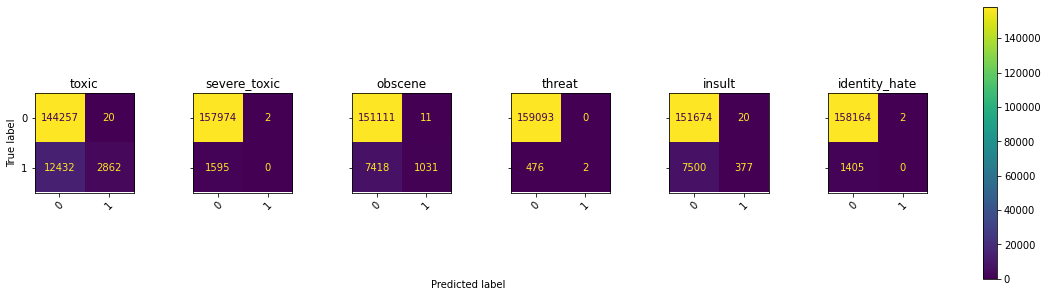

In [ ]:
steps = [('tfid', TfidfVectorizer(stop_words="english")),('model', MultinomialNB())]
cv = StratifiedKFold()
NB_model = Pipeline(steps=steps)
f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')
for i,category in enumerate(categories):
  NB_y_pred = cross_val_predict(NB_model, X_train_dtm, df[category], cv=cv, n_jobs=-1)
  # NB_model.fit(X_train_dtm,train[category])
  # NB_y_pred=NB_model.predict(X_test_dtm)
  cm=confusion_matrix(df[category],NB_y_pred)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title(category)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')
  print(category)
  # print("f1",f1_score(df[category],NB_y_pred,average="macro"))
  print("roc auc",roc_auc_score(df[category],NB_y_pred,average="macro"))
  print('precision',precision_score(df[category],NB_y_pred,average="macro"))
  print('recall',recall_score(df[category],NB_y_pred,average="macro"))
f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.60, hspace=0.4)


f.colorbar(disp.im_, ax=axes)
plt.show()

# PART 2: Deep Learning for Toxic Text Classification

## **BINARY N-GRAM WITH TF-IDF VECTORIZATION**

In [ ]:
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras 
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

In [ ]:
Y_train_dtm=df[categories].values
Y_test_dtm=df_test[categories].values
X_train=df["comment_text"].values
X_test=df["comment_text"].values

In [ ]:
print("X Train: {}\nY_train: {}\nX_test: {}\nY_test: {}".format(X_train.shape,Y_train_dtm.shape,X_test.shape,Y_test_dtm.shape))

X Train: (159571,)
Y_train: (159571, 6)
X_test: (159571,)
Y_test: (63978, 6)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train_dtm, test_size=0.2, random_state=42)

In [ ]:
print("X Train: {}\nY_train: {}\nX_test: {}\nY_test: {}".format(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape))

X Train: (127656,)
Y_train: (127656, 6)
X_test: (31915,)
Y_test: (31915, 6)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer(max_features=20000,stop_words="english",ngram_range=(2,2))
X_train=vect.fit_transform(X_train)
X_val=vect.transform(X_val)

In [ ]:
print("X Train: {}\nY_train: {}\nX_test: {}\nY_test: {}".format(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape))

X Train: (127656, 20000)
Y_train: (127656, 6)
X_test: (31915, 20000)
Y_test: (31915, 6)


In [ ]:
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    # processed_inputs=TfidfVectorizer(max_features=20000,stop_words="english",ngram_range=(2,2))(inputs)
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=['AUC'])
    return model

  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 320,118
Trainable params: 320,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3990/3990 [==============================] - 25s 5ms/step - loss: 0.1772 - auc: 0.7029 - val_loss: 0.1320 - val_auc: 0.8268
Epoch 2/10
3990/3990 [==============================] - 22s 5ms/step - loss: 0.1338 - auc: 0.8159 - val_loss: 0.1326 - val_auc: 0.8284
Epoch 3/10
3990/3990 [==============================] - 24s 6ms/step - loss: 0.1336 - auc: 0.8277 - val_loss: 0.1347 - val_auc: 0.8294
Epoch 4/10
3990/3990 [==============================] - 20s 5ms/step - loss: 0.1347 - auc: 0.8308 - val_loss: 0.1362 - val_auc: 0.8287
Epoch 5/10
3990/3990 [==============================] - 20s 5ms/step - loss: 0.1365 - auc: 0.8318 - val_loss: 0.1372 - val_auc: 0.8313
Epoch 6/10
3990/3990 [==============================] - 21s 5ms/step - loss: 0.1375 - auc: 0.8327 - val_loss: 0.1389 - val_auc: 0.8295
Epoch 7/10
3990/3990 [==============================] - 19s 5ms/step - loss: 0.1393 - auc: 0.8324 - val_loss: 0.1394 - val_auc: 0.8301
Epoch 8/10
3990/3990 [==============================] - 20s 5ms/st

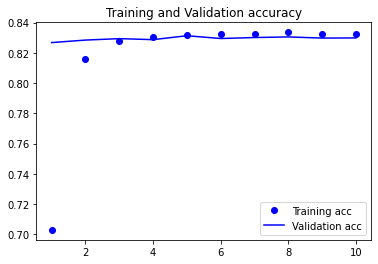

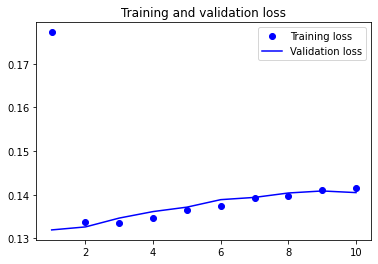

In [ ]:
# X_train.flatten()
model = get_model(X_train.shape[1])
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
import scipy
X_train.sort_indices()
X_val.sort_indices()
history=model.fit(X_train,Y_train,                   
          validation_data=(X_val,Y_val),     
          epochs=10,
          callbacks=callbacks
          )
acc=history.history["auc"]
val_acc=history.history["val_auc"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,"bo", label="Training acc")
plt.plot(epochs,val_acc,"b", label="Validation acc")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
df_train,df_val = train_test_split(df.drop(columns='id'), test_size=0.2, random_state=42)

In [ ]:
X_train=df_train['comment_text'].values
Y_train=df_train[categories].values
X_val=df_val['comment_text'].values
Y_val=df_val[categories].values

In [ ]:
max_length = 600
max_tokens = 30000
text_vectorization = layers.TextVectorization(
max_tokens=max_tokens,
output_mode="int",
output_sequence_length=max_length,
)
text_only_train_ds = X_train
text_vectorization.adapt(text_only_train_ds)

In [ ]:
X_train_ts=text_vectorization(X_train)
X_val_ts=text_vectorization(X_val)

## BI-DIRECTIONAL LSTM

One thing that’s slightly hurting model performance here is that our input sequences
are full of zeros. This comes from our use of the output_sequence_length=max_
length option in TextVectorization (with max_length equal to 600): sentences longer
than 600 tokens are truncated to a length of 600 tokens, and sentences shorter
than 600 tokens are padded with zeros at the end so that they can be concatenated
together with other sequences to form contiguous batches.

We need some way to tell the RNN that it should skip these iterations. There’s an
API for that: masking.
The Embedding layer is capable of generating a “mask” that corresponds to its
input data. This mask is a tensor of ones and zeros (or True/False booleans), of shape
(batch_size, sequence_length), where the entry mask[i, t] indicates where timestep
t of sample i should be skipped or not (the timestep will be skipped if mask[i, t]
is 0 or False, and processed otherwise).

Let’s try retraining our model with masking enabled.

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["AUC"])
model.summary()
callbacks = [
keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
save_best_only=True)
]
model.fit(X_train_ts,Y_train, validation_data=(X_val_ts,Y_val), epochs=10,
callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
int_test_ds=text_vectorization(df_test['comment_text'])
print(f"Test acc: {model.evaluate(int_test_ds,df_test[categories])[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         7680000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 7,754,374
Trainable params: 7,754,374
Non-trainable params: 0
_________________________________________________

## GLOVE PRE-TRAINED WORD EMBEDDINGS

Sometimes you have so little training data available that you can’t use your data alone
to learn an appropriate task-specific embedding of your vocabulary. In such cases,
instead of learning word embeddings jointly with the problem you want to solve, you
can load embedding vectors from a precomputed embedding space that you know is
highly structured and exhibits useful properties—one that captures generic aspects of
language structure. The rationale behind using pretrained word embeddings in natural
language processing is much the same as for using pretrained convnets in image
classification: you don’t have enough data available to learn truly powerful features on
your own, but you expect that the features you need are fairly generic—that is, common
visual features or semantic features. In this case, it makes sense to reuse features
learned on a different problem.

In [ ]:
!wget http:/ /nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-16 16:59:34--  ftp://http//
           => ‘.listing’
Resolving http (http)... failed: Name or service not known.
wget: unable to resolve host address ‘http’
/nlp.stanford.edu/data/glove.6B.zip: Scheme missing.
unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


In [ ]:
import numpy as np
path_to_glove_file = "/content/drive/My Drive/Datasets/Kaggle/WordEmbeddings/glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Next, let’s build an embedding matrix that you can load into an Embedding layer. It
must be a matrix of shape (max_words, embedding_dim), where each entry i contains
the embedding_dim-dimensional vector for the word of index i in the reference word
index (built during tokenization).

In [ ]:
embedding_dim = 100
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
  if i < max_tokens:
    embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

Finally, we use a Constant initializer to load the pretrained embeddings in an Embedding
layer. So as not to disrupt the pretrained representations during training, we freeze
the layer via `trainable=False`:

In [ ]:
embedding_layer = layers.Embedding(
max_tokens,
embedding_dim,
embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False,
mask_zero=True,
)

We’re now ready to train a new model—identical to our previous model, but leveraging
the 100-dimensional pretrained GloVe embeddings instead of 128-dimensional
learned embeddings.

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["AUC"])
model.summary()
callbacks = [
keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
save_best_only=True)
]
history=model.fit(X_train_ts,Y_train, validation_data=(X_val_ts,Y_val), epochs=10,
callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
int_test_ds=text_vectorization(df_test['comment_text'])
print(f"Test acc: {model.evaluate(int_test_ds,df_test[categories])[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         3000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 3,034,438
Trainable params: 34,438
Non-trainable params: 3,000,000
____________________________________________

You’ll find that on this particular task, pretrained embeddings aren’t very helpful,
because the dataset contains enough samples that it is possible to learn a specialized
enough embedding space from scratch. However, leveraging pretrained embeddings
can be very helpful when you’re working with a smaller dataset.

## **TRANSFORMERS**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
  
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                         
        self.dense_dim = dense_dim                         
        self.num_heads = num_heads                         
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):                    
        if mask is not None:                              
            mask = mask[:, tf.newaxis, :]                 
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
  
    def get_config(self):                                 
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

Transformer was a hybrid approach that is technically order-agnostic, but that manually injects order information in the representations it processes. This is the missing ingredient! It’s called positional encoding.

The original “Attention is all you need” paper used an interesting trick to encode word positions: it added to the word embeddings a vector containing values in the range [-1, 1] that varied cyclically depending on the position (it used cosine functions to achieve this). This trick offers a way to uniquely characterize any integer in a large range via a vector of small values. It’s clever, but it’s not what we’re going to use in our case. We’ll do something simpler and more effective: we’ll learn position-embedding vectors the same way we learn to embed word indices. We’ll then proceed to add our position embeddings to the corresponding word embeddings, to obtain a position-aware word embedding. This technique is called “positional embedding.”

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):  
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(                          
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)              
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
  
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions                        
 
    def compute_mask(self, inputs, mask=None):                             
        return tf.math.not_equal(inputs, 0)                                
 
    def get_config(self):                                                  
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
vocab_size = 20000 
sequence_length = 600 
embed_dim = 256 
num_heads = 2 
dense_dim = 32 
  
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)   
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["AUC"])
model.summary()
  
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
] 
history=model.fit(X_train_ts,Y_train, validation_data=(X_val_ts,Y_val), epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding}) 
int_test_ds=text_vectorization(df_test['comment_text'])
print(f"Test acc: {model.evaluate(int_test_ds,df_test[categories])[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

# Conclusion

The above analysis shows that the Logistic regression with a BOW model gave us the best results with almost 99% AUC. On the other hand bi-gram and deep learning fell short in terms of performance. It is fair to say that sometimes the simplest model is the best model. We were able to see how all these models are implemented and how they performed. 